# Chapter 07 - Ensemble Learning and Random Forests

## Voting Classifiers

### Concept and example

By ensembling many weak classifiers, we can get a stronger classifier by choosing as the predicted class the one that is most predicted between the wrong classifiers. 

The Law of Large Numbers support this idea. Suppose you have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

In [8]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure ch07_law_of_large_numbers_plot


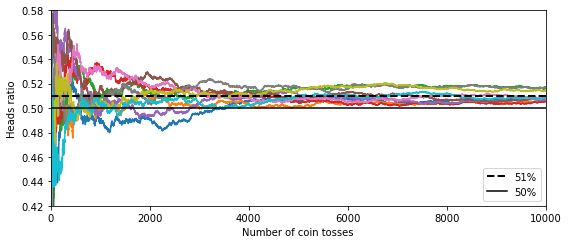

In [10]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("ch07_law_of_large_numbers_plot")
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

In [11]:
# Example of code
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), 
                                          ("svc", svm_clf)], voting="hard"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [13]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


If all classifiers are able to estimate class probabilities (i.e., they all have a *predict_proba()* method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities. This is not the case for the SVC class by default, so you need to set its *probability* hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a *predict_proba()* method). If you modify the preceding code  to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy!

## Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed without replacement, it is called *pasting*.

### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the *BaggingClassifier* class (or *BaggingRegressor* for regression). The following code trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set *bootstrap=False*). The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                           max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

#### Out-of-Bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a *BaggingClassifier* samples m training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set *oob_score=True* when creating a *BaggingClassifier* to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable:

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

### Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. Sampling is controlled by two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the Random Patches method. Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by setting bootstrap_features to True and/or max_features to a value smaller than 1.0) is called the Random Subspaces method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a *RandomForestClassifier* has all the hyperparameters of a *DecisionTreeClassifier* (to control how trees are grown), plus all the hyperparameters of a *BaggingClassifier* to control the ensemble itself.

The following *BaggingClassifier* is roughly equivalent to the previous *RandomForestClassifier*:

In [18]:
# bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
#                             n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an Extremely Randomized Trees ensemble (or Extra-Trees for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class.

### Feature importances

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it (see Chapter 6).

In [19]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09102505632162221
sepal width (cm) 0.022940635670108123
petal length (cm) 0.43230099312096976
petal width (cm) 0.45373331488729995


## Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

### AdaBoost

The AdaBoost algorithm consists of a technique that tries to fix the classification errors done by a simpler classifier. For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

Let’s take a closer look at the AdaBoost algorithm. Eachh instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set:

$$
r_j = \frac{\sum_{i=1, \hat{y}_j^{(i)} \neq y^{(i)}}^m w^{(i)}} {\sum_{i=1}^m w^{(i)}}
$$

where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.

The predictor's weight $\alpha_j$ is then computed using equation 7-2, where $\eta$ is the learning rate. The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

$$\alpha_j = \eta \log \frac{1 - r_j}{r_j}$$

Next, the AdaBoost algorithm updates the instance weights, using Equation 7-3, which boosts the weights of the misclassified instances.

For i = 1, 2, ..., m

$$
w^{(i)} \leftarrow 
\begin{cases}
w^{(i)} & if \hat{y}_j^{(i)} = y^{(i)}, \\
w^{(i)}\exp(\alpha_j)& if \hat{y}_j^{(i)} \neq y^{(i)},
\end{cases}
$$

Then all instances weights are normalized (i.e. divided by $\sum_{i=1}^m w^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the
predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes (see Equation 7-4).

$$
\hat{y}(x) = argmax_k \sum_{j=1, \hat{y}_j(x) = k}^N \alpha_j
$$

where $N$ is the number of predictors.

Scikit-Learn uses a multiclass version of AdaBoost called SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                            algorithm="SAMME.R", learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting

Another very popular boosting algorithm is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, **instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor**.

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [29]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [30]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [40]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


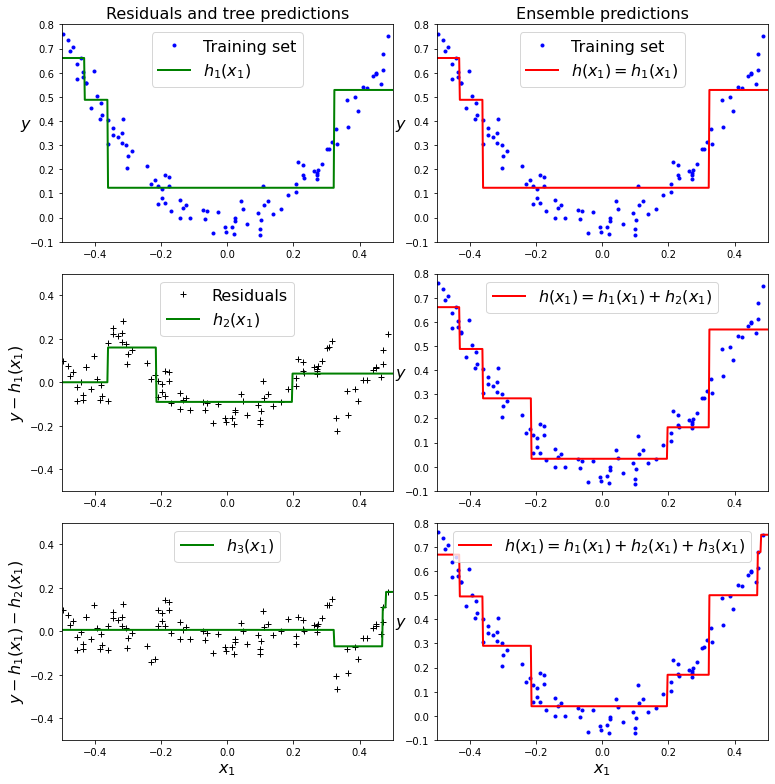

In [41]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In order to find the optimal number of trees, you can use early stopping (see Chapter 4). A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [49]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

In [50]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [51]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


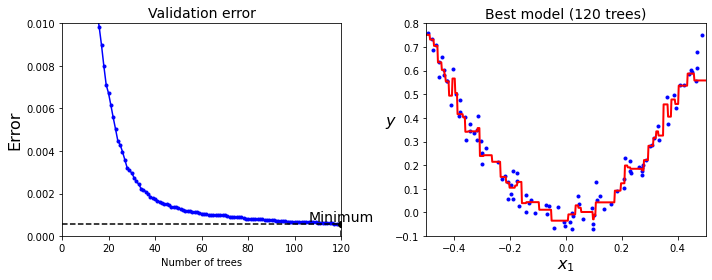

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting warm_start=True, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training

In [53]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called Stochastic Gradient Boosting.

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular Python library XGBoost, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims to be extremely fast, scalable, and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [55]:
# import xgboost

# xgb_reg = xgboost.XGBRegressor()
# xgb_reg.fit(X_train, y_train)
# y_pred = xgb_reg.predict(X_val)

In [56]:
# xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
# y_pred = xgb_reg.predict(X_val)